### Downloading the Data

In [1]:
import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 25.9/25.9 MB 430.3 kB/s eta 0:00:00


In [4]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [6]:
len(df.columns)

19

### Computing Duration

In [15]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.dt.total_seconds() /60

In [16]:
df.duration.mean()

15.668995167332046

In [17]:
df.duration.std()

42.594351241920904

### Dropping Outliers

In [18]:
len(df[(df.duration >= 1) & (df.duration <= 60)]) / len(df) * 100

98.1220282212598

In [19]:
df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

### One Hot Encoding

In [20]:
categorical = ['PULocationID', 'DOLocationID']

In [22]:
df[categorical] = df[categorical].astype(str)

In [23]:
train_dicts = df[categorical].to_dict(orient='records')

In [24]:
dv = DictVectorizer()

In [25]:
X_train = dv.fit_transform(train_dicts)

In [26]:
print(f'Feature matrix size: {X_train.shape}')

Feature matrix size: (3009173, 515)


### Training a Model

In [27]:
target = 'duration'

In [28]:
y_train = df[target].values

In [29]:
lr = LinearRegression()

In [30]:
lr.fit(X_train, y_train)

LinearRegression()

In [31]:
y_pred = lr.predict(X_train)

In [33]:
print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 7.649262059796709


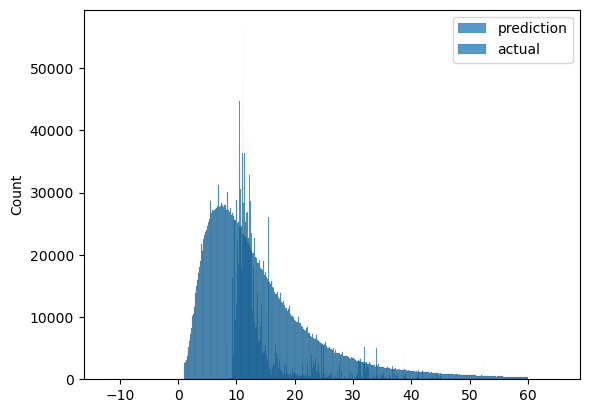

In [34]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='actual')

plt.legend();

### Evaluating the Model

In [35]:
categorical = ['PULocationID', 'DOLocationID']

def read_data(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.dt.total_seconds() / 60

    df = df[(df.duration >= 1) & (df.duration <= 60)].copy()

    df[categorical] = df[categorical].astype('str')
    
    return df

In [36]:
df_val = read_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

In [37]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [38]:
X_val = dv.transform(val_dicts) 
y_val = df_val.duration.values

In [39]:
y_pred = lr.predict(X_val)

In [40]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 7.811815861712645
